In [1]:
choices = ['Rock', 'Paper', 'Scissors', 'Lizard', 'Spock']
payoffs = {
    'Rock': 3, 'Paper': 2, 'Scissors': 1, 'Lizard': 4, 'Spock': 5
}

# Outcomes from the perspective of the first choice
outcomes = {
    ('Rock', 'Scissors'): 'win', ('Rock', 'Lizard'): 'win',
    ('Paper', 'Rock'): 'win', ('Paper', 'Spock'): 'win',
    ('Scissors', 'Paper'): 'win', ('Scissors', 'Lizard'): 'win',
    ('Lizard', 'Spock'): 'win', ('Lizard', 'Paper'): 'win',
    ('Spock', 'Scissors'): 'win', ('Spock', 'Rock'): 'win'
}

counter_moves = {
    'Rock': ['Paper', 'Spock'], 
    'Paper': ['Scissors', 'Lizard'], 
    'Scissors': ['Rock', 'Spock'], 
    'Lizard': ['Rock', 'Scissors'], 
    'Spock': ['Paper', 'Lizard']
}

lose_moves = {
    'Rock': ['Scissors', 'Lizard'], 
    'Paper': ['Rock', 'Spock'], 
    'Scissors': ['Paper', 'Lizard'], 
    'Lizard': ['Paper', 'Spock'], 
    'Spock': ['Scissors', 'Rock']
}



In [2]:
# Example for a Random Strategy
import random
import pandas as pd

class Strategy:
    def next_move(self, history):
        raise NotImplementedError

class RandomStrategy(Strategy):
    def next_move(self, history):
        return random.choice(choices)

class FixedStrategy(Strategy):
    def __init__(self, idx=4):
        self.choices = ['Rock', 'Paper', 'Scissors', 'Lizard', 'Spock']
        self.move = self.choices[idx]
    
    def next_move(self, history):
        # Randomly choose between Lizard and Spock
        return self.move

class CopyStrategy(Strategy):
    def __init__(self, player_1_2=1):
        self.player = player_1_2
    def next_move(self, history):
        # If it's the first move, choose randomly
        if not history:
            return random.choice(choices)
        # Otherwise, copy the opponent's last move
        else:
            # history[-1][1] refers to the opponent's last move
            if self.player == 1: return history[-1][1]
            return history[-1][0]



/var/folders/1v/knqhfv_x1l9394z3p0ypxmzh0000gn/T/ipykernel_7163/3912361732.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
class AdaptiveStrategy(Strategy):
    def __init__(self, player_1_2=1, memory_length=10):
        self.player = player_1_2
        self.memory_length = memory_length
    
    def next_move(self, history):
        # If it's the first move, or no history is available, choose randomly
        if not history:
            return random.choice(choices)
        
        # Count the frequency of the opponent's moves
        if self.player==1:
            opponent_moves = [it[1] for it in history]
        else:
            opponent_moves = [it[0] for it in history]
        if len(opponent_moves)>self.memory_length:
            opponent_moves = opponent_moves[-self.memory_length:]
        move_frequency = {move: opponent_moves.count(move) for move in choices}
        
        # Find the opponent's most frequent move
        most_frequent_move = max(move_frequency, key=move_frequency.get)
        
        # Based on the opponent's most frequent move, decide our move
        # The strategy here is to beat the most frequent move of the opponent

        return random.choice( counter_moves[most_frequent_move] )

In [4]:
class TryToLoseStrategy(Strategy):
    def __init__(self, player_1_2=1, memory_length=10):
        self.player = player_1_2
        self.memory_length = memory_length

    def next_move(self, history):
        # If it's the first move, or no history is available, choose randomly
        if not history:
            return random.choice(choices)
        
        # Determine the opponent's moves based on perspective
        if self.player == 1:
            opponent_moves = [it[1] for it in history]
        else:
            opponent_moves = [it[0] for it in history]
        
        # Limit the memory to the most recent moves if necessary
        if len(opponent_moves) > self.memory_length:
            opponent_moves = opponent_moves[-self.memory_length:]
        
        # Count the frequency of the opponent's moves
        move_frequency = {move: opponent_moves.count(move) for move in choices}
        
        # Find the opponent's most frequent move
        most_frequent_move = max(move_frequency, key=move_frequency.get)
        
        return random.choice( lose_moves[most_frequent_move] )


In [5]:
def simulate_round(strategy1, strategy2, history):
    move1 = strategy1.next_move(history)
    move2 = strategy2.next_move(history)
    # Determine outcome and update scores
    if (move1, move2) in outcomes: 
        return move1, move2, +payoffs[move1], -payoffs[move2]
    elif move1 == move2:
        return move1, move2, 0, 0
    else:
        return move1, move2, -payoffs[move1], +payoffs[move2] 

def run_simulation(strategy1, strategy2, num_rounds=100):
    history = []
    scores = [0, 0]  # [strategy1_score, strategy2_score]
    for _ in range(num_rounds):
        m1, m2, s1, s2 = simulate_round(strategy1, strategy2, history)
        scores[0] += s1
        scores[1] += s2
        history.append( (m1, m2, s1, s2) )
        # Update history and scores
    return history, scores 


## Simulations

### random vs any others

- random vs all fixed: expected points (???:0)




In [25]:
total = [0, 0, 0]
player1_scores, player2_scores = [], []
player1_win, player2_win = [], []

for times in range(100):
       num_rounds = 1000
       lst = [
              ("FixedStrategy", FixedStrategy(4)), 
              ("CopyStrategy", CopyStrategy(2)), 
              ("AdaptiveStrategy", AdaptiveStrategy(2, num_rounds)),
              ("TryToLoseStrategy", TryToLoseStrategy(2, num_rounds))
              ]
       strategy1 = RandomStrategy()
       (name, strategy2) = lst[0]
       #print( "RandomStrategy vs", name )
       history, scores = run_simulation(strategy1, strategy2, num_rounds)
       #print("scores: player 1 vs player 2, ", scores)
       if scores[0]>scores[1]: total[0] += 1
       elif scores[0]<scores[1]: total[1] += 1
       else: total[2] += 1
       player1_scores.append( scores[0] )
       player2_scores.append( scores[1] )
       if scores[0] > scores[1]: 
              player1_win.append( 1 )
              player2_win.append( 0 )
       elif scores[0] < scores[1]:
              player1_win.append( 0 )
              player2_win.append( 1 )
       else: 
              player1_win.append( 0 )
              player2_win.append( 0 )

df = pd.DataFrame()   
df[ 'score1' ] = player1_scores
df[ 'score2' ] = player2_scores
df[ 'win1' ] = player1_win
df[ 'win2' ] = player2_win
total, #df['score1'].mean(), df['score2'].mean(), df['score1'].std(), df['score2'].std() 

([100, 0, 0],)

<Axes: >

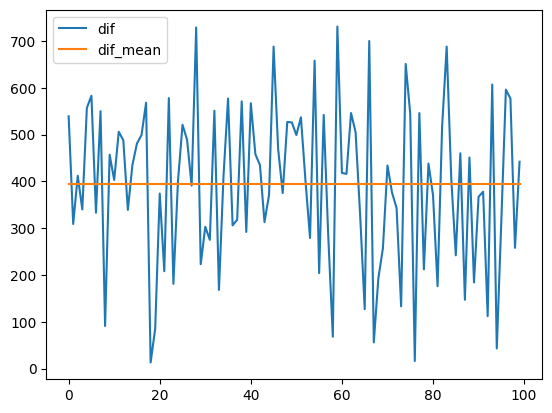

In [32]:
# score difference through out 100 times, random vs fixed(Spock)
df['dif'] = df[ 'score1' ] - df[ 'score2' ]
df['dif_mean'] = df['dif'].mean()
df[['dif', 'dif_mean']].plot()

### fixed vs the rest

- fixed vs copy: degrade to 1 round

In [102]:
total = [0, 0, 0]
player1_scores, player2_scores = [], []
for times in range(1000):
       num_rounds = 100
       lst = [
              ("CopyStrategy", CopyStrategy(2)), 
              ("AdaptiveStrategy", AdaptiveStrategy(2, num_rounds)),
              ("TryToLoseStrategy", TryToLoseStrategy(2, num_rounds))
              ]
       strategy1 = FixedStrategy()
       (name, strategy2) = lst[2]
       #print( "RandomStrategy vs", name )
       history, scores = run_simulation(strategy1, strategy2, num_rounds)
       #print("scores: player 1 vs player 2, ", scores)
       if scores[0]>scores[1]: total[0] += 1
       elif scores[0]<scores[1]: total[1] += 1
       else: total[2] += 1
       player1_scores.append( scores[0] )
       player2_scores.append( scores[1] )
df = pd.DataFrame()
df[ 'score1' ] = player1_scores
df[ 'score2' ] = player2_scores
total, df['score1'].mean(), df['score2'].mean(), df['score1'].std(), df['score2'].std() 

[1000, 0, 0]

### Copy vs the rest

In [103]:
total = [0, 0, 0]
player1_scores, player2_scores = [], []
for times in range(1000):
       num_rounds = 100
       lst = [ 
              ("AdaptiveStrategy", AdaptiveStrategy(2, num_rounds)),
              ("TryToLoseStrategy", TryToLoseStrategy(2, num_rounds))
              ]
       strategy1 = CopyStrategy(1)
       (name, strategy2) = lst[1]
       #print( "RandomStrategy vs", name )
       history, scores = run_simulation(strategy1, strategy2, num_rounds)
       #print("scores: player 1 vs player 2, ", scores)
       if scores[0]>scores[1]: total[0] += 1
       elif scores[0]<scores[1]: total[1] += 1
       else: total[2] += 1
       player1_scores.append( scores[0] )
       player2_scores.append( scores[1] )
df = pd.DataFrame()
df[ 'score1' ] = player1_scores
df[ 'score2' ] = player2_scores
total, df['score1'].mean(), df['score2'].mean(), df['score1'].std(), df['score2'].std() 

[954, 40, 6]

### Adaptive vs Try to lose

In [104]:
total = [0, 0, 0]
player1_scores, player2_scores = [], []
for times in range(1000):
       num_rounds = 100
       lst = [ 
              ("TryToLoseStrategy", TryToLoseStrategy(2, num_rounds))
              ]
       strategy1 = AdaptiveStrategy(1, num_rounds)
       (name, strategy2) = lst[0]
       #print( "RandomStrategy vs", name )
       history, scores = run_simulation(strategy1, strategy2, num_rounds)
       #print("scores: player 1 vs player 2, ", scores)
       if scores[0]>scores[1]: total[0] += 1
       elif scores[0]<scores[1]: total[1] += 1
       else: total[2] += 1
       player1_scores.append( scores[0] )
       player2_scores.append( scores[1] )
df = pd.DataFrame()
df[ 'score1' ] = player1_scores
df[ 'score2' ] = player2_scores
total, df['score1'].mean(), df['score2'].mean(), df['score1'].std(), df['score2'].std() 

[1000, 0, 0]

### Long vs Short Memory
- why short wins?

In [113]:
total = [0, 0, 0]
player1_scores, player2_scores = [], []
for times in range(1000):
       num_rounds = 100
       lst = [ 
              ("AdaptiveStrategy", AdaptiveStrategy(2, 50))
              ]
       strategy1 = AdaptiveStrategy(1, num_rounds)
       (name, strategy2) = lst[0]
       #print( "RandomStrategy vs", name )
       history, scores = run_simulation(strategy1, strategy2, num_rounds)
       #print("scores: player 1 vs player 2, ", scores)
       if scores[0]>scores[1]: total[0] += 1
       elif scores[0]<scores[1]: total[1] += 1
       else: total[2] += 1
       player1_scores.append( scores[0] )
       player2_scores.append( scores[1] )
df = pd.DataFrame()
df[ 'score1' ] = player1_scores
df[ 'score2' ] = player2_scores
total, df['score1'].mean(), df['score2'].mean(), df['score1'].std(), df['score2'].std()

([473, 521, 6], -0.567, 3.056, 30.95761432805966, 31.276494098333384)

In [34]:
import collections
dic1 = collections.Counter(list(map(lambda x:x[0], history)))
dic2 = collections.Counter(list(map(lambda x:x[1], history)))
dic1, dic2 


(Counter({'Rock': 211,
          'Paper': 207,
          'Lizard': 203,
          'Scissors': 191,
          'Spock': 188}),
 Counter({'Spock': 1000}))

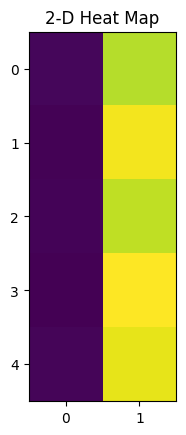

In [39]:
import numpy as np
import matplotlib.pyplot as plt

data = []
moves_to_num = {  'Rock':1, 'Paper':2, 'Scissors':3, 'Lizard':4, 'Spock':5 }
for k in dic1:
    v1 = moves_to_num[k]
    v2 = dic1[k]
    data.append( (v1,v2) )
plt.imshow( data )

plt.title( "2-D Heat Map" )
plt.show()